In [1]:

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
# imprt tree
from sklearn import tree
# import metrics
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
df_raw = pd.read_csv("labeled_data/skipped/015_5.csv", encoding_errors="ignore", on_bad_lines='skip', sep=",",
                    usecols=[ 'CustomerID', 'AgeCategory', 'Gender', 'Office_U', 'Office_W',
                    'SessionID', 'IPID', 'TIMESTAMP', 'VHOST', 'Activity', 'PAGE_NAME',
                    'REF_URL_category', 'page_load_error', 'page_action_detail', 'tip',
                    'service_detail', 'xps_info','anomaly'])
# df_raw["TIMESTAMP"] = pd.to_datetime(df_raw["TIMESTAMP"], infer_datetime_format=True)
# df_raw = df_raw.sort_values(by=["SessionID", "TIMESTAMP"]).copy()

In [3]:
# count the number of unique SessionID where anomaly == True
count_anomaly_raw = df_raw[df_raw["anomaly"] == True]["SessionID"].nunique()
count_normal_raw = df_raw[df_raw["anomaly"] == False]["SessionID"].nunique()
print(f'Amount of anomalous sessions in the dataset:   {count_anomaly_raw}' )
print(f'Amount of normal sessions in the dataset:      {count_normal_raw}')
distribution =  count_anomaly_raw / count_normal_raw 
print(f'Distribution:                                  {distribution * 100} %')

Amount of anomalous sessions in the dataset:   277
Amount of normal sessions in the dataset:      659993
Distribution:                                  0.04197014210756781 %


In [4]:
df_anomaly = df_raw[df_raw["anomaly"] == True].copy()
df_normal = df_raw[df_raw["anomaly"] == False].copy()

# get 20 random sessionIDs from the anomaly dataset
anomaly_sessionIDs = df_anomaly["SessionID"].sample(n=20, random_state=1).tolist()
first_20_anomaly = df_anomaly["SessionID"].unique()[:20]

df_anomaly.to_csv("gen_sessions/skipped/an.csv", index=False)
anomaly_sessionIDs

[38288755,
 28695620,
 15964883,
 19488771,
 50182157,
 11410404,
 5106814,
 48244991,
 23484246,
 30969666,
 10646215,
 30208173,
 30352354,
 22976331,
 40544634,
 49749606,
 7161329,
 51399395,
 1012979,
 49749606]

In [5]:
nr_of_sessions_used = 50000
# pick random int > 0 and < (len(df_raw) - nr_of_sessions_used)
lower = np.random.randint(0, len(df_raw) - nr_of_sessions_used)
upper = lower + nr_of_sessions_used
print(f'Lower bound: {lower}')
print(f'Upper bound: {lower + nr_of_sessions_used}')
# get a random sample of the sessions
# df_ = df_raw[df_raw["SessionID"].isin(df_raw["SessionID"].unique()[:nr_of_sessions_used])].copy()
df_ = df_normal[df_normal["SessionID"].isin(df_normal["SessionID"].unique()[:nr_of_sessions_used])].copy()
df_ = df_.append(df_anomaly[df_anomaly["SessionID"].isin(anomaly_sessionIDs)], ignore_index=True)
# Only use the columns that are needed -> SessionID, Activity, anomaly
df_50k = df_[["SessionID", "Activity", "anomaly"]]

Lower bound: 6230472
Upper bound: 6280472


In [6]:
# count the number of unique SessionID where anomaly == True
count_anomaly = df_50k[df_50k["anomaly"] == True]["SessionID"].nunique()
count_normal = df_50k[df_50k["anomaly"] == False]["SessionID"].nunique()
print(f'Amount of anomalous sessions in the sampled dataset:   {count_anomaly}')
print(f'Amount of normal sessions in the sampled dataset:      {count_normal}')
distribution =  count_anomaly / count_normal 
print(f'Distribution:                                          {distribution * 100} %')

Amount of anomalous sessions in the sampled dataset:   19
Amount of normal sessions in the sampled dataset:      50000
Distribution:                                          0.038 %


Helper Functions

In [7]:
# function to encode the activities
def encode_activities(_df):
    df = _df.copy()
    le = LabelEncoder()
    le.fit(df)
    df= le.transform(df)
    return df

# function to create a list of al the activities
def activities_list(_df):
  df = _df.copy()
  activities = []
  for i in df["Activity"].unique():
    activities.append(i)
  return activities

# function to create a dictionary with the activities as keys and the one hot encoded activities as values
def create_dict(l1, l2):
  dic = {}
  for i in range(len(l1)):
    dic[l1[i]] = l2[i]
  return dic

# function to transform each session into a sequence of activities
def transform_session_to_sequence(_df):
  df = _df.copy()
  df_ses = df.groupby("SessionID")["Activity"].apply(list).reset_index()
  # merge the anomaly column
  df_ses = df_ses.merge(df[["SessionID", "anomaly"]].drop_duplicates(), on="SessionID")
  return df_ses

# function the create the dataFrame for the model
def df_for_model(_df,Activity_col):
  df = pd.DataFrame(_df[Activity_col].values.tolist(), index= _df.index)
  df_for_model = pd.concat([_df, df], axis=1)
  df_for_model = df_for_model.drop(columns=[Activity_col])
  df_for_model.fillna(0, inplace=True)
  return df_for_model
  
# function to concat 2 dataframes
def concat_df(df_gen ,amount_real,amount_generated,_df1 = df_raw,):
  df1 = _df1.copy()
  df2 = df_gen
  df_raw_filtered = df1[df1["SessionID"].isin(df1["SessionID"].unique()[:amount_real])]
  df_gen_anomalies_filtered = df2[df2["SessionID"].isin(df2["SessionID"].unique()[:amount_generated])]
  df = pd.concat([df_raw_filtered, df_gen_anomalies_filtered], ignore_index=True)
  return df

GLOBALS

In [8]:
# Global variables
# list of all possible activities in df_raw
ALL_ACTIVITIES = activities_list(df_raw)
ENCODED_ACTIVITIES = encode_activities(ALL_ACTIVITIES)
DICT = create_dict(ALL_ACTIVITIES, ENCODED_ACTIVITIES)
if len(ALL_ACTIVITIES) == len(ENCODED_ACTIVITIES) == len(DICT):
  print("All lists are the same length")

All lists are the same length


Stappenplan:

1. df -> transform_session_to_sequence
2. Transform Activities to encoded Activities
3. Transform the list in the Activity column to multiple columns with fillna(0)

In [9]:
base_data = transform_session_to_sequence(df_50k)
# base_an = transform_session_to_sequence(df_50k)

In [10]:
base_data['Activity'] = base_data['Activity'].apply(lambda x: [DICT[i] for i in x])
# base_an['Activity'] = base_an['Activity'].apply(lambda x: [DICT[i] for i in x])

In [11]:
base_data = df_for_model(base_data, "Activity")
# base_an = df_for_model(base_an, "Activity")

In [12]:
base_data
# drop the SessionID column
base_data = base_data.drop(columns=["SessionID"])
base_data

,anomaly,0,1,2,3,4,5,6,7,8,...,355,356,357,358,359,360,361,362,363,364
0,False,372,371.0,392.0,391.0,391.0,391.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,False,369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,False,391,372.0,401.0,391.0,391.0,391.0,391.0,369.0,367.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,False,372,372.0,372.0,372.0,372.0,372.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,391,391.0,391.0,391.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50014,True,372,372.0,723.0,398.0,398.0,398.0,398.0,398.0,398.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50015,True,238,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50016,True,398,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50017,True,372,372.0,371.0,365.0,365.0,365.0,635.0,41.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Functions to run the model

In [13]:
# Function to split the data into train and test data
def split_data(_df):
  df = _df.copy()
  X = df.drop(columns=["anomaly"])
  y = df["anomaly"]
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [14]:
# Base test and train data
X_train, X_test, y_train, y_test = split_data(base_data)

In [15]:
# Le = LabelEncoder()
# Le.fit(y_train)
# y_train_transformed = Le.transform(y_train)
# y_test_transformed = Le.transform(y_test)
# y_train_transformed

Run the model

In [16]:
# import the generated sessions:
base_path = "gen_sessions/skipped/"
gen_sessions_paths = [
  base_path + '5_1000.csv',
  base_path + '10_1000.csv',
  base_path + '15_1000.csv',
  # base_path + '25_1000.csv',
  # base_path + '50_1000.csv',
  # base_path + '80_1000.csv',
  # base_path + '100_1000.csv',
  base_path + 'an.csv',
]

In [17]:
auc_score_dicts = {}
dict_prec_and_rec_list = {}

amount_anomalies_list_total = []
precision_score_list_total = []
recall_score_list_total = []

gen_sessions/skipped/5_1000.csv 0
0.4996500699860028

gen_sessions/skipped/5_1000.csv 25
0.4997000599880024

gen_sessions/skipped/5_1000.csv 50
0.49875024995001

gen_sessions/skipped/5_1000.csv 75
0.4988502299540092

gen_sessions/skipped/5_1000.csv 100
0.4986502699460108

gen_sessions/skipped/5_1000.csv 125
0.498250349930014

gen_sessions/skipped/5_1000.csv 150
0.4981003799240152

gen_sessions/skipped/5_1000.csv 175
0.4980503899220156

gen_sessions/skipped/5_1000.csv 200
0.4977004599080184

gen_sessions/skipped/5_1000.csv 225
0.49750049990002

gen_sessions/skipped/5_1000.csv 250
0.4978004399120176

[0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


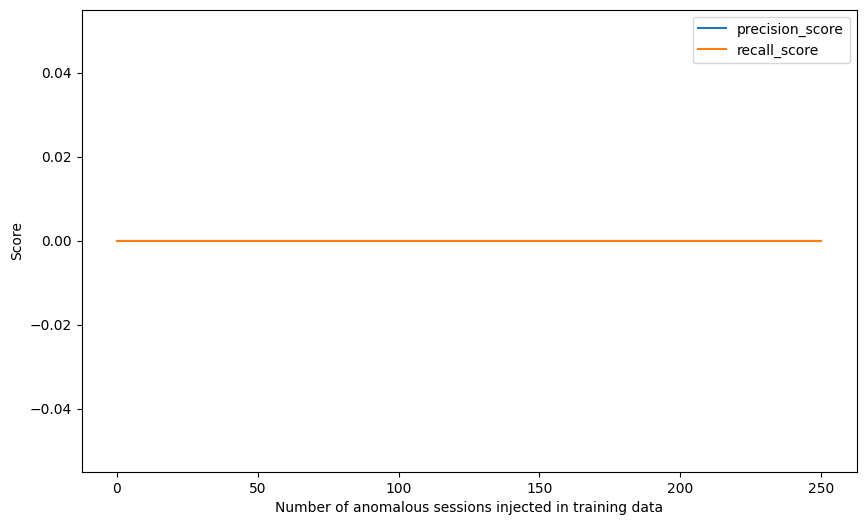

gen_sessions/skipped/10_1000.csv 0
0.4997000599880024

gen_sessions/skipped/10_1000.csv 25
0.499250149970006

gen_sessions/skipped/10_1000.csv 50
0.499250149970006

gen_sessions/skipped/10_1000.csv 75
0.4989002199560088

gen_sessions/skipped/10_1000.csv 100
0.7486002799440111

gen_sessions/skipped/10_1000.csv 125
0.4984003199360128

gen_sessions/skipped/10_1000.csv 150
0.4983503299340132

gen_sessions/skipped/10_1000.csv 175
0.4981003799240152

gen_sessions/skipped/10_1000.csv 200
0.4974505098980204

gen_sessions/skipped/10_1000.csv 225
0.4971005798840232

gen_sessions/skipped/10_1000.csv 250
0.4966006798640272

[0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250] [0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


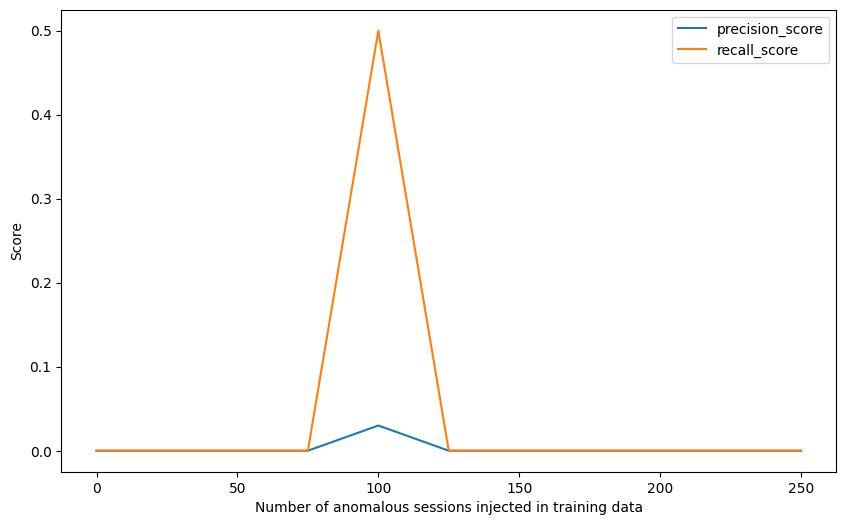

gen_sessions/skipped/15_1000.csv 0
0.4997000599880024

gen_sessions/skipped/15_1000.csv 25
0.4993501299740052

gen_sessions/skipped/15_1000.csv 50
0.4989002199560088

gen_sessions/skipped/15_1000.csv 75
0.4989502099580084

gen_sessions/skipped/15_1000.csv 100
0.498500299940012

gen_sessions/skipped/15_1000.csv 125
0.7487002599480104

gen_sessions/skipped/15_1000.csv 150
0.4986502699460108

gen_sessions/skipped/15_1000.csv 175
0.4975504899020196

gen_sessions/skipped/15_1000.csv 200
0.7473005398920216

gen_sessions/skipped/15_1000.csv 225
0.4970505898820236

gen_sessions/skipped/15_1000.csv 250
0.4969006198760248

[0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250] [0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.02, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.5, 0.0, 0.0]


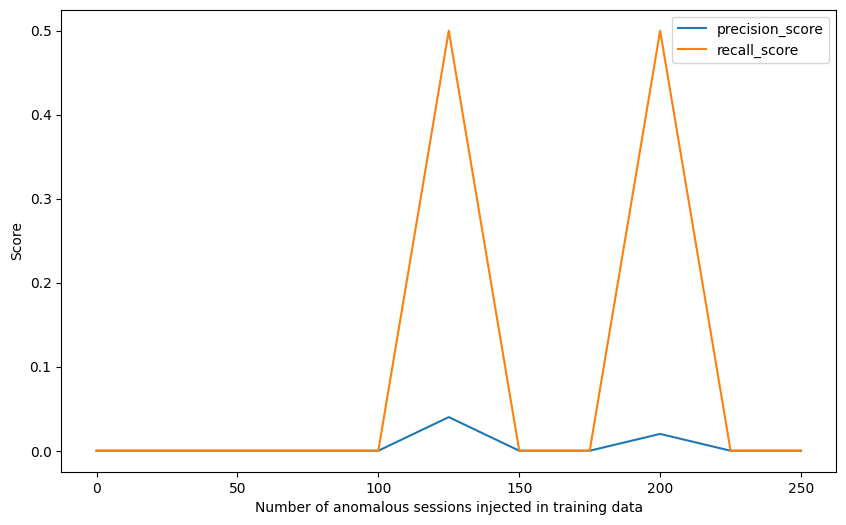

gen_sessions/skipped/an.csv 0
0.4996500699860028

gen_sessions/skipped/an.csv 25
0.499250149970006

gen_sessions/skipped/an.csv 50
0.499000199960008

gen_sessions/skipped/an.csv 75
0.4989002199560088

gen_sessions/skipped/an.csv 100
0.7485502899420117

gen_sessions/skipped/an.csv 125
0.9982503499300139

gen_sessions/skipped/an.csv 150
0.9977504499100179

gen_sessions/skipped/an.csv 175
0.9977004599080185

gen_sessions/skipped/an.csv 200
0.9977504499100179

gen_sessions/skipped/an.csv 225
0.9974505098980204

gen_sessions/skipped/an.csv 250
0.9974505098980204

[0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250] [0.0, 0.0, 0.0, 0.0, 0.03, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04] [0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


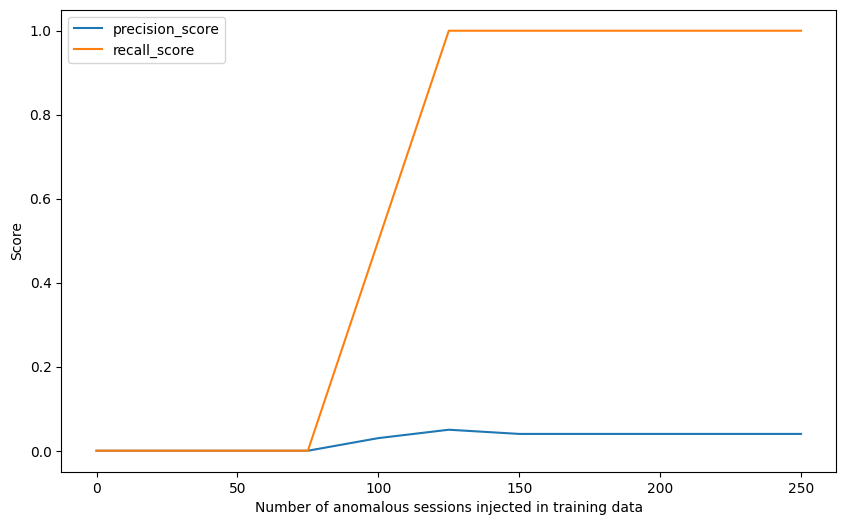

In [18]:
for sessions in gen_sessions_paths:
    amount_anomalies_list = []
    precision_score_list = []
    recall_score_list = []
    
    # build the dataFrame
    cvs = pd.read_csv(sessions)
    cvs['anomaly'] = True
    gen_df_seq = transform_session_to_sequence(cvs)
    
    gen_df_seq['Activity'] = gen_df_seq['Activity'].apply(lambda x: [DICT[i] for i in x])
    ready_df = df_for_model(gen_df_seq, "Activity")
    ready_df = ready_df.drop(columns=["SessionID"])
    ready_df = ready_df.sample(frac=1).reset_index(drop=True)
    # change the sessionID to something useable
    # first remove everything before the last _
    # ready_df['SessionID'] = ready_df['SessionID'].apply(lambda x: x.split('_')[-1])
    # ready_df['SessionID'] = ready_df['SessionID'].astype(int)
    
    
    # for amount_gen in [10, 20, 50, 65, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    # from 0 to 250 with a step of 25
    for amount_gen in [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]:
        amount_real = 0
        df_gen = ready_df[:amount_gen]
        # print(df_gen)
        # Add the generated anomalies to the training dataset
        X_train_extra = pd.concat([X_train, df_gen.drop(columns=["anomaly"])]).fillna(0)
        y_train_extra = pd.concat([y_train, df_gen["anomaly"]])
        
        #transform y values to binary class
        Le = LabelEncoder()
        Le.fit(y_train_extra)
        y_train_transformed = Le.transform(y_train)
        y_test_transformed = Le.transform(y_test)
        y_train_extra_transformed = Le.transform(y_train_extra)
        
        #Make sure that both dataframes have the same columns
        for column_name in X_train_extra.columns:
            if column_name not in X_test.columns:
                X_test[column_name] = 0

        #Make sure that both dataframes have the same columns
        for column_name in X_test.columns:
            if column_name not in X_train_extra.columns:
                X_test.drop(columns=[column_name], inplace=True)
                
        clf = tree.DecisionTreeClassifier()
        # clf = LogisticRegression(random_state=0, max_iter=1000)

        clf = clf.fit(X_train_extra, y_train_extra_transformed)
        y_test_predict = clf.predict(X_test)
        
        #AUC predict
        fpr, tpr, thresholds = metrics.roc_curve(y_test_transformed, y_test_predict)
        print(sessions, amount_gen)
        print(metrics.auc(fpr, tpr))
        print()
        auc_score_dicts[(sessions, amount_gen)] = metrics.auc(fpr, tpr)
        
        precision_score = [i for i in classification_report(y_test_transformed, y_test_predict).split(" ") if len(i) > 2][8]
        recall_score = [i for i in classification_report(y_test_transformed, y_test_predict).split(" ") if len(i) > 2][9]

        amount_anomalies_list.append(amount_gen)
        precision_score_list.append(precision_score)
        recall_score_list.append(recall_score)
                
        # print(f'Session: {sessions}')
        # print(f'Amount of injected anomalies: {amount_gen}')
        # print("Accuracy:",metrics.accuracy_score(y_test, y_test_predict))
        # balanced_accuracy_score = metrics.balanced_accuracy_score(y_test, y_test_predict)
        # print("Balanced accuracy:", balanced_accuracy_score)
    amount_anomalies_list = [int(i) for i in amount_anomalies_list]
    precision_score_list = [float(i) for i in precision_score_list]
    recall_score_list = [float(i) for i in recall_score_list]
    print(amount_anomalies_list, precision_score_list, recall_score_list)
    
    string_recall = "recall_" + str(sessions)
    string_precision = "precision_" + str(sessions)
    dict_prec_and_rec_list[string_recall] = recall_score_list
    dict_prec_and_rec_list[string_precision] = precision_score_list
    
    plt.figure(figsize=(10, 6))
    plt.plot(amount_anomalies_list, precision_score_list, label = "precision_score")
    plt.plot(amount_anomalies_list, recall_score_list, label = "recall_score")
    plt.xlabel("Number of anomalous sessions injected in training data")
    plt.ylabel("Score")
    save_string = "prec_rec_scores/" + str(sessions.split(".")[0].split("/")[1] + sessions.split(".")[0].split("/")[2]) + ".png"    
    plt.legend()
    plt.savefig(save_string)
    plt.show()
    
       
        
